# Notebook for calculating correlations from .sm files and average them

## Insert folder name containing the .sm files to analyze. 

In [9]:
FolderName = r'X:\Temporary\CAV-3D-MP_paper\uFCS\20220623_FCS_miniMIC-1a_W60x.1.20_PH25_dsDNA-T1-Cy3B_10nM_downstairs\PH10_2\25uW_2'

## Give a name for these data and insert duration of a single measurement. 

In [10]:
name = r'Alexa546 50nM glass slides'
Measurement_time=60 #in seconds

## What do you want to correlate?

### Possiblities are: 'donor' or  'acceptor'

In [11]:
Channel = 'donor'

## Loading standard things, do not change

In [12]:
!pip install pycorrelate
!pip install Binning

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import optimize
import pycorrelate as pyc

plt.style.use('seaborn-talk')
import matplotlib.gridspec as gridspec
from Binning import *
import struct

#Microscope/software specific parameter
time_resolution = 1.25e-08
channel_flip = False
start_green = 0
start_red = 99e-05
period_shift = 0.0
alex_period = 0.0001
#Background parameter
threshold = 10          #average background for all bins with less photons than theshold defines
binning_time = 0.00000001    #binning size in s ( standard)

## Find number .sm of files in folder

In [15]:
for file in os.listdir(FolderName):
    if file.endswith('.sm'):
        FileList = [os.path.join(FolderName, f) for f in os.listdir(FolderName) if f.endswith('.sm')]

## Calculating the auto-correlations for each file and the average correlation

In [16]:
#Creating delay times in number of microtime units
n_group = 5
bin_widths = []
for i in range(24):
    bin_widths += [2**i]*n_group
np.array(bin_widths)
bins = np.hstack(([0], np.cumsum(bin_widths)))[21:]

G = np.zeros((len(bins)-1,len(FileList)))
Intensity=np.zeros(len(FileList))

index=0

if Channel == 'donor':
    ch_number=0
elif Channel == 'acceptor':
    ch_number=2

for i in FileList:
        data = read_to_np(str(i), time_resolution, channel_flip,period_shift,alex_period,start_green,start_red)
        index_channel = np.where(data['FinalChannel'] == ch_number)
        FCS=data['ArrivalTime'][index_channel]/time_resolution
        G_temp = pyc.pcorrelate(FCS,FCS, bins, normalize=True)-1
        G[:,index]=G_temp
        Intensity[index]=np.size(FCS)/Measurement_time
        index = index + 1
    
averageFCS=np.mean(G,axis=1)
averageIntensity=np.mean(Intensity)

1.2499991025144127e-08 9.999999999994403e-05
3.5114597861374275e-17 9.999999999998485e-05
1.2499991452441755e-08 9.99999999999482e-05
6.993104012531504e-18 9.999999999999483e-05
1.2499992083433867e-08 9.99999999999811e-05
1.2499991488464372e-08 9.999999999998679e-05
1.249999138714568e-08 9.999999999997503e-05
2.3052848692473038e-17 9.999999999995908e-05
1.2499991461698131e-08 9.999999999998605e-05
1.249999165314113e-08 9.999999999995412e-05


In [17]:
Intensity

array([15388.8       , 15398.53333333, 15388.43333333, 15369.33333333,
       15138.28333333, 15166.13333333, 15207.36666667, 15116.95      ,
       14973.25      , 14743.48333333])

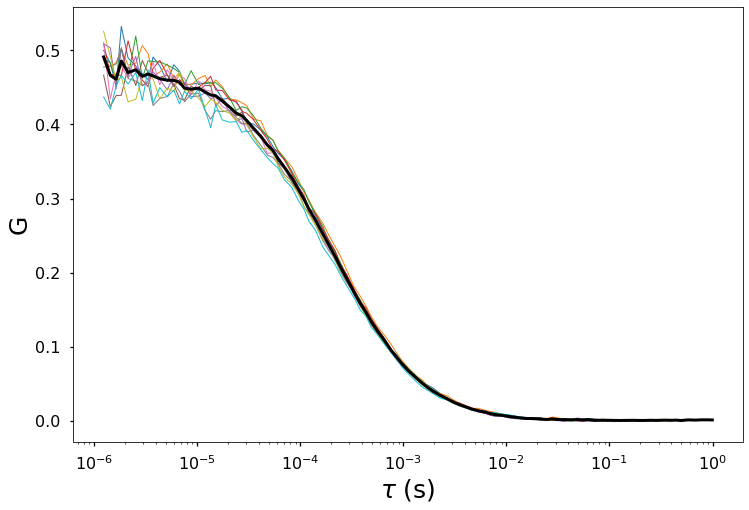

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*time_resolution,G,linewidth=1,label='Correlation')
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*time_resolution,averageFCS,color='black',linewidth=3,label='Average correlation')

ax.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax.set_ylabel(r'G',fontsize=25)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
#ax.set_xlim(0.01,1)
#ax.set_ylim(0,0.1)


#ax.legend()

plt.show()

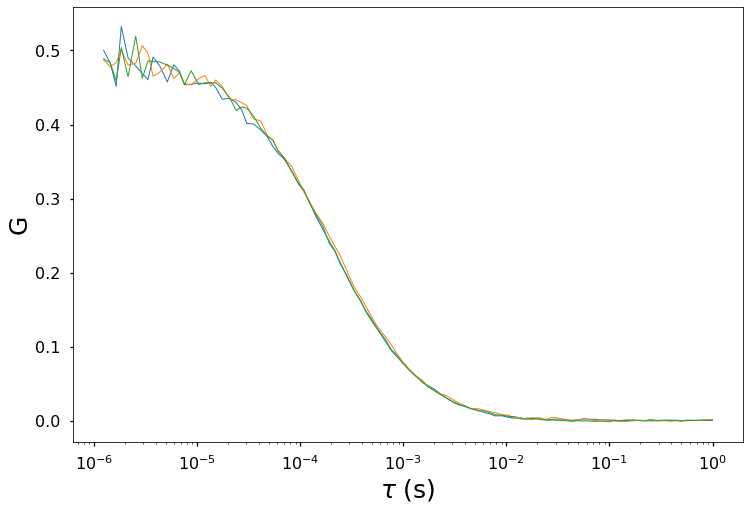

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
ax.semilogx(np.mean([bins[1:], bins[:-1]], 0)*time_resolution,G[:,0:3],linewidth=1,label='Correlation')

ax.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax.set_ylabel(r'G',fontsize=25)
ax.xaxis.set_tick_params(labelsize=16)
ax.yaxis.set_tick_params(labelsize=16)
#ax.set_xlim(0.01,1)
#ax.set_ylim(0,0.1)


#ax.legend()

plt.show()

In [20]:
dataset=range(len(FileList))
averageFCS=np.mean(G[:,dataset],axis=1)

In [21]:
#Save the figure as a pdf
fig.savefig(name + ' raw data.pdf', dpi=300, bbox_inches = 'tight')

# Fitting correlation curves

In [22]:
#Standard model, only considering diffusion
def FCS(t, Nmol, difftime, kappa):
    return (1/Nmol) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa**2)*difftime)))**(-0.5)

In [23]:
#Extended model where a triplet fraction is included
def FCSTrip(t, N, difftime, kappa, Tfrac, triptime):
    return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))

In [24]:
#Fitting the average correlation curve
xdataFCS=np.mean([bins[1:], bins[:-1]], 0)*time_resolution

#We only use the diffusion with triplet
paramsFCS, params_covarianceFCS = optimize.curve_fit(FCSTrip, xdataFCS[1:], averageFCS[1:], p0=[np.round(1/averageFCS[0],2),75e-6,10,0.05,10e-6],method='lm')
print(paramsFCS)

print('Brightness =')
print(np.round(averageIntensity/paramsFCS[0]))

#Output format:
#Triplet [Number of particles in confocal volume, Diffusion time (s), Aspect ratio, Triplet fraction, Triplet time (ms)]

[ 2.11450269e+00  2.15770124e-04 -5.75863539e+00  4.66183522e-02
  3.37021956e-05]
Brightness =
7183.0


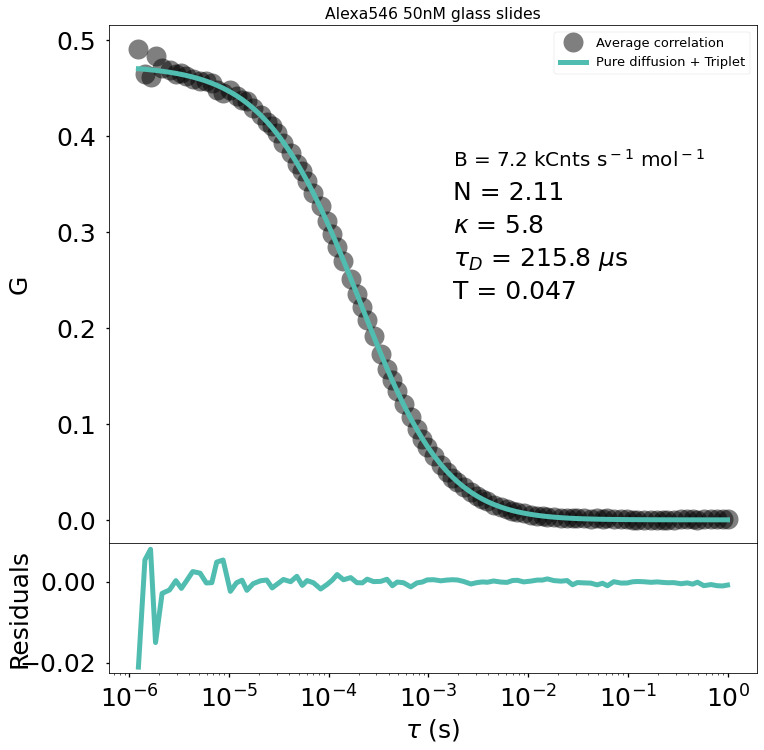

In [63]:
figure1 = plt.figure(1, figsize=(10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.25], figure=figure1)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.02, hspace=0)

#Plot the FCS data and fit
ax1 = plt.subplot(gs[0,0])
ax1.semilogx(xdataFCS, averageFCS, 'o', label='Average correlation',color='black', markersize=10, alpha=0.7)
ax1.semilogx(xdataFCS,FCSTrip(xdataFCS, paramsFCS[0], paramsFCS[1],paramsFCS[2], paramsFCS[3], paramsFCS[4]),
         label='Pure diffusion + Triplet',color='#50bdb0', linewidth=5)

ax1.set_ylabel(r'G',fontsize=25)
ax1.yaxis.set_tick_params(labelsize=25)
ax1.set_xlabel(r' ') # Force this empty !
ax1.set_xticklabels([]) # Force this empty !
ax1.get_yaxis().set_label_coords(-0.12,0.5)


ax1.text(10**(-2.75), 0.75*averageFCS[0], r'B = '+str(np.round(0.001*averageIntensity/paramsFCS[0],1))+' kCnts s$^-$$^1$ mol$^-$$^1$', fontsize=20)
ax1.text(10**(-2.75), 0.68*averageFCS[0], r'N = '+ str(np.round(paramsFCS[0],2)), fontsize=25)
ax1.text(10**(-2.75), 0.61*averageFCS[0], r'$\kappa$ = '+ str(np.round(np.absolute(paramsFCS[2]),1)), fontsize=25)
ax1.text(10**(-2.75), 0.54*averageFCS[0], r'$\tau$$_D$ = '+ str(np.round(paramsFCS[1]*10**6,1))+' $\mu$s', fontsize=25)
ax1.text(10**(-2.75), 0.47*averageFCS[0], r'T = '+ str(np.round(paramsFCS[3],3)), fontsize=25)

ax1.set_title(name)
ax1.legend()


#Plot the residuals
ax2= plt.subplot(gs[1,0])
ax2.semilogx(xdataFCS,(FCSTrip(xdataFCS, paramsFCS[0], paramsFCS[1],paramsFCS[2], paramsFCS[3], paramsFCS[4])-averageFCS),
         label='Pure diffusion + Triplet',color='#50bdb0',linewidth=5.0)

ax2.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax2.set_ylabel(r'Residuals',fontsize=25)
ax2.xaxis.set_tick_params(labelsize=25)
ax2.yaxis.set_tick_params(labelsize=25)
ax2.get_yaxis().set_label_coords(-0.12,0.5)


plt.show()

In [64]:
#Save the figure as a pdf
figure1.savefig(name + '.pdf',dpi=300, bbox_inches = 'tight')

# SPECIAL: Fitting with structural parameter fixed

In [24]:
kappa_fixed = 5

In [25]:
#Standard model, only considering diffusion
def FCSfixed(t, Nmol, difftime):
    return (1/Nmol) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5)

In [26]:
#Extended model where a triplet fraction is included
def FCSTripfixed(t, N, difftime, Tfrac, triptime):
    return (1/N) * (1 + (t/difftime))**(-1) * (1 + (t/((kappa_fixed**2)*difftime)))**(-0.5) * ((1 - Tfrac + Tfrac * np.exp(-(t/triptime))/(1-Tfrac)))

In [27]:
#Fitting the average correlation curve
xdataFCS=np.mean([bins[1:], bins[:-1]], 0)*time_resolution

#We only use the diffusion with triplet
paramsFCSfixed, params_covarianceFCSfixed = optimize.curve_fit(FCSTripfixed, xdataFCS, averageFCS, p0=[np.round(1/averageFCS[0],2),100e-6,0.1,10e-6],method='lm')
print(paramsFCSfixed)

print('Brightness =')
print(np.round(averageIntensity/paramsFCSfixed[0]))

#Output format:
#Triplet [Number of particles in confocal volume, Diffusion time (s), Aspect ratio, Triplet fraction, Triplet time (ms)]

[1.91995735e+00 2.73559959e-04 1.44119943e-01 9.52868160e-06]
Brightness =
76770.0


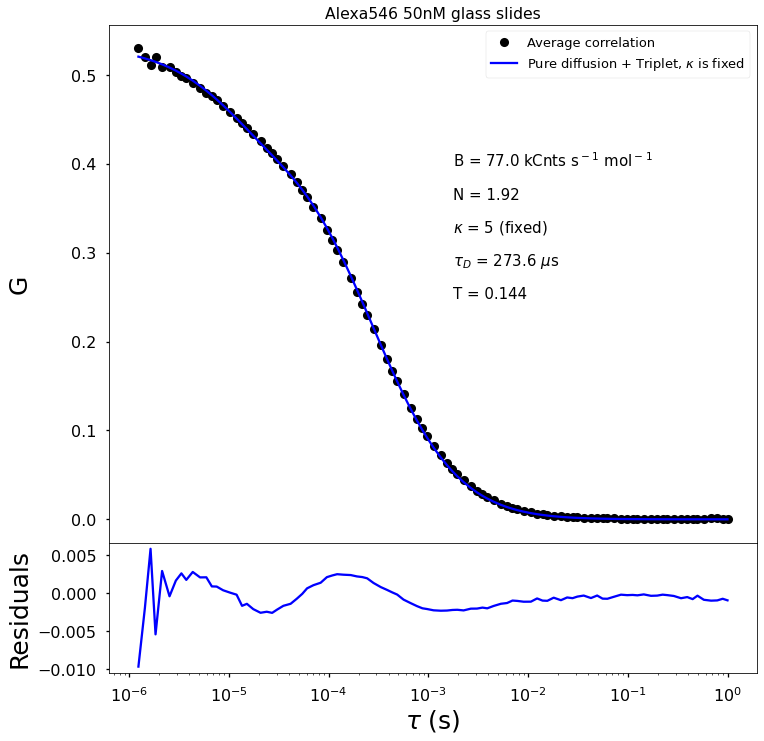

In [28]:
figure2 = plt.figure(1, figsize=(10,10))
gs = gridspec.GridSpec(2, 1, height_ratios=[1,0.25], figure=figure2)
gs.update(left=0.05, right=0.95, bottom=0.05, top=0.95, wspace=0.02, hspace=0)

#Plot the FCS data and fit
ax1 = plt.subplot(gs[0,0])
ax1.semilogx(xdataFCS, averageFCS, 'o', label='Average correlation',color='black')
ax1.semilogx(xdataFCS,FCSTripfixed(xdataFCS, paramsFCSfixed[0], paramsFCSfixed[1],paramsFCSfixed[2], paramsFCSfixed[3]),
         label='Pure diffusion + Triplet, $\kappa$ is fixed',color='blue')

ax1.set_ylabel(r'G',fontsize=25)
ax1.yaxis.set_tick_params(labelsize=16)
ax1.set_xlabel(r' ') # Force this empty !
ax1.set_xticklabels([]) # Force this empty !
ax1.get_yaxis().set_label_coords(-0.12,0.5)

#Add parameters to plot
ax1.text(10**(-2.75), 0.75*averageFCS[0], r'B = '+str(np.round(0.001*averageIntensity/paramsFCSfixed[0]))+' kCnts s$^-$$^1$ mol$^-$$^1$', fontsize=15)
ax1.text(10**(-2.75), 0.68*averageFCS[0], r'N = '+ str(np.round(paramsFCSfixed[0],2)), fontsize=15)
ax1.text(10**(-2.75), 0.61*averageFCS[0], r'$\kappa$ = '+ str(kappa_fixed)+' (fixed)', fontsize=15)
ax1.text(10**(-2.75), 0.54*averageFCS[0], r'$\tau$$_D$ = '+ str(np.round(paramsFCSfixed[1]*10**6,1))+' $\mu$s', fontsize=15)
ax1.text(10**(-2.75), 0.47*averageFCS[0], r'T = '+ str(np.round(paramsFCSfixed[2],3)), fontsize=15)

ax1.set_title(name)
ax1.legend()


#Plot the residuals
ax2= plt.subplot(gs[1,0])
ax2.semilogx(xdataFCS,FCSTripfixed(xdataFCS, paramsFCSfixed[0], paramsFCSfixed[1],paramsFCSfixed[2], paramsFCSfixed[3])-averageFCS,
         label=r'Pure diffusion + Triplet fixed $\kappa$',color='blue')


ax2.set_xlabel(r'$\tau$ (s)',fontsize=25)
ax2.set_ylabel(r'Residuals',fontsize=25)
ax2.xaxis.set_tick_params(labelsize=16)
ax2.yaxis.set_tick_params(labelsize=16)
ax2.get_yaxis().set_label_coords(-0.12,0.5)


plt.show()

In [87]:
#Save the figure as a pdf
figure2.savefig(name + ' kappa fixed.pdf',dpi=300, bbox_inches = 'tight')